In [1]:
from IPython.display import Image
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Convolution2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.transform import resize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_LOCATION = '../data/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'
IMAGE_SIZE = 64

In [3]:
train_labels = pd.read_csv(DATA_LOCATION + 'train_onelabel.csv')
train_labels = train_labels.rename(columns={'image': 'filepath'})
#train_labels = train_labels.sample(n=2000)

In [43]:
def get_image(row):
    """
    Load image from filepath to a numpy.ndarray
    input:
        - filepath: string with relative or absolute path to image
    output:
        - img:
            numpy.ndarray containing the image
            shaped (M,N), values [0.0, 1.0]
    """
    try:
        img = TRAIN_IMAGES_LOCATION + row['filepath']
        img = mpimg.imread(img)
    except:
        img = row
        img = mpimg.imread(img)
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    return img

def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))
    
def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')
    
def resize_image(img, size):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (size,size), mode='reflect')

def flattened_image(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - Python list, flattened np.ndarray
    """
    img = get_image(row)
    img = pad_image(img)
    img = resize_image(img, IMAGE_SIZE)
    return img.flatten().tolist()

def get_shape(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - tuple, with original image dimensions
    """
    img = get_image(row)
    return img.shape

def rotate(array):
    return [array]+[ np.rot90(array,i) for i in range(1,4)]

In [7]:
# get image from file
# pad the image to a sqaure
# resize to IMAGE_SIZE
# flatten and convert np.array to Python list
train_labels['image'] = train_labels.apply(flattened_image, axis=1)

In [8]:
train_labels.sample(n=10)

,filepath,class,image
23931,131166.jpg,119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12691,144298.jpg,58,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1781,2323.jpg,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16714,45086.jpg,84,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16368,127585.jpg,81,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21465,33865.jpg,105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13637,22735.jpg,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4166,45830.jpg,17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14397,39851.jpg,67,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9811,7573.jpg,45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


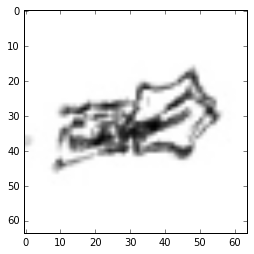

In [46]:
example = train_labels.sample(n=1).iloc[0]['image']
example = np.asarray(example).reshape(IMAGE_SIZE,IMAGE_SIZE)
plt.imshow(example,cmap='binary')

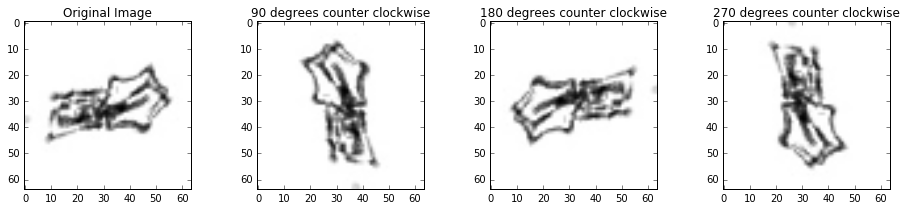

In [49]:
# Rotation example
f = plt.figure(figsize=(16,3))

rotated = rotate(example)
sub1 = plt.subplot(1,4,1)
plt.imshow(rotated[0], cmap='binary')
sub1.set_title("Original Image")
sub2 = plt.subplot(1,4,2)
plt.imshow(rotated[1], cmap='binary')
sub2.set_title("90 degrees counter clockwise")
sub3 = plt.subplot(1,4,3)
plt.imshow(rotated[2], cmap='binary')
sub3.set_title("180 degrees counter clockwise")
sub4 = plt.subplot(1,4,4)
sub4.set_title("270 degrees counter clockwise")
plt.imshow(rotated[3], cmap='binary')

In [8]:
# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels['class'])
# Find the unique numbers from the train labels
classes = np.unique(train_labels['class'])
nClasses = len(classes)

In [9]:
train_data = train_labels['image'].values

In [10]:
for i in range(len(train_data)):
    train_data[i] = np.asarray(train_data[i])

# format it in such a way Keras can use it
print('{}, {}'.format(train_data.shape, train_data[0].shape))
train_data = np.array(train_data.tolist())
print('{}'.format(train_data.shape))

(24204,), (4096,)
(24204, 4096)


In [12]:
def model_first(train_data, train_labels_one_hot):
    model_reg = Sequential()
    model_reg.add(Dense(512, activation='relu', input_shape=(IMAGE_SIZE**2,)))
    model_reg.add(Dropout(0.5))
    model_reg.add(Dense(512, activation='relu'))
    model_reg.add(Dropout(0.5))
    model_reg.add(Dense(nClasses, activation='softmax'))

    model_reg.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history_reg = model_reg.fit(train_data, train_labels_one_hot, batch_size=256, epochs=20, verbose=1)
    
    model_reg.save('../data/output/models/model1.h5')
    model_reg.summary()

# model_first(train_data, train_labels_one_hot)

Epoch 1/20
24204/24204 [==============================] - 14s - loss: 3.5230 - acc: 0.2146    
Epoch 2/20
24204/24204 [==============================] - 14s - loss: 2.8193 - acc: 0.3264    
Epoch 3/20
24204/24204 [==============================] - 14s - loss: 2.5033 - acc: 0.3723    
Epoch 4/20
24204/24204 [==============================] - 14s - loss: 2.2945 - acc: 0.4102    
Epoch 5/20
24204/24204 [==============================] - 14s - loss: 2.1407 - acc: 0.4348    
Epoch 6/20
24204/24204 [==============================] - 13s - loss: 2.0275 - acc: 0.4580    
Epoch 7/20
24204/24204 [==============================] - 14s - loss: 1.9212 - acc: 0.4774    
Epoch 8/20
24204/24204 [==============================] - 14s - loss: 1.8433 - acc: 0.4940    
Epoch 9/20
24204/24204 [==============================] - 15s - loss: 1.7678 - acc: 0.5123    
Epoch 10/20
24204/24204 [==============================] - 14s - loss: 1.7068 - acc: 0.5207    
Epoch 11/20
24204/24204 [========================

In [15]:
# reshape it to work with Convolutional layers
# after this, input layer will always have: input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)
train_data = np.reshape(train_data, (-1,64,64,1))
print('{}'.format(train_data.shape))

(24204, 64, 64, 1)


In [18]:
def model_single_conv(train_data, train_labels_one_hot):
    # takes roughly 1 hour to train
    model_a = Sequential()
    model_a.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1), padding='same', activation='relu'))
    model_a.add(MaxPooling2D(pool_size=(2, 2)))
    model_a.add(Flatten())
    model_a.add(Dense(512, activation='relu'))
    model_a.add(Dropout(0.5))
    model_a.add(Dense(nClasses, activation='softmax'))

    model_a.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history_a = model_a.fit(train_data, train_labels_one_hot, batch_size=128, epochs=20, verbose=1)

    model_a.save('../data/output/models/model3.h5')

    model_a.summary()

# model_single_conv(train_data, train_labels_one_hot)

Epoch 1/20
24204/24204 [==============================] - 194s - loss: 2.9233 - acc: 0.3138   
Epoch 2/20
24204/24204 [==============================] - 184s - loss: 2.1563 - acc: 0.4378   
Epoch 3/20
24204/24204 [==============================] - 182s - loss: 1.8523 - acc: 0.5037   
Epoch 4/20
24204/24204 [==============================] - 174s - loss: 1.6318 - acc: 0.5538   
Epoch 5/20
24204/24204 [==============================] - 171s - loss: 1.4770 - acc: 0.5928   
Epoch 6/20
24204/24204 [==============================] - 172s - loss: 1.3362 - acc: 0.6249   
Epoch 7/20
24204/24204 [==============================] - 199s - loss: 1.1982 - acc: 0.6581   
Epoch 8/20
24204/24204 [==============================] - 181s - loss: 1.0874 - acc: 0.6878   
Epoch 9/20
24204/24204 [==============================] - 187s - loss: 0.9886 - acc: 0.7126   
Epoch 10/20
24204/24204 [==============================] - 200s - loss: 0.8948 - acc: 0.7363   
Epoch 11/20
24204/24204 [========================

In [19]:
def model_double_conv():
    # takes roughly 3 hours to train
    model_a = Sequential()
    model_a.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1), padding='same', activation='relu'))
    model_a.add(Dropout(0.5))
    model_a.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model_a.add(MaxPooling2D(pool_size=(2, 2)))
    model_a.add(Flatten())
    model_a.add(Dense(512, activation='relu'))
    model_a.add(Dropout(0.5))
    model_a.add(Dense(nClasses, activation='softmax'))

    model_a.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history_a = model_a.fit(train_data, train_labels_one_hot, batch_size=128, epochs=20, verbose=1)

    model_a.save('../data/output/models/model3.h5')

    model_a.summary()
    
# model_double_conv(train_data, train_labels_one_hot)